### Explore the Wiki Loves Monuments initiative 

Additional links and resources can be found at this **[link](https://docs.google.com/document/d/1OSDQL4DzlFUVjDFjnuDsoG1FyHAeG4FvYL2iLV-i3Mk/edit)**.

In [1]:
try:
    import geopandas
except ImportError as e:
    !pip install geopandas

try:
    import matplotlib
except ImportError as e:
    !pip install matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib 
from matplotlib import pyplot as plt

In [3]:
PROJECT_BASE_DIR = "../data/"

**Characterize the Wikipedia Monuments database**

https://heritage.toolforge.org

In [4]:
monuments = pd.read_csv(PROJECT_BASE_DIR+"monuments_all_table.csv.bz2", error_bad_lines=False, warn_bad_lines=False)

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (3,6,7,8,12,13,14,15,17,18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
import matplotlib.pyplot as plt

attrs = ["page_id", "img_name", "img_timestamp"]

def is_valid_lon(value):
    return isinstance(value, float) and value>=-180 and value<=180

def is_valid_lat(value):
    return isinstance(value, float) and value>=-90 and value<=90

In [6]:
def plot_wlm_spatial_distribution(data):
    if isinstance(data, gpd.GeoDataFrame):
        f, ax = plt.subplots(figsize=(12,12), dpi=150)
        ax.axis('off')
        data.plot(ax = ax, markersize=0.2)

In [7]:
geolocated_monuments = monuments[monuments.apply(lambda x: is_valid_lon(x.lon) and is_valid_lat(x.lat), axis=1)]

In [8]:
geolocated_monuments = gpd.GeoDataFrame(geolocated_monuments, 
                                        geometry=gpd.points_from_xy(
                                            geolocated_monuments.lon, 
                                            geolocated_monuments.lat)
                                       )

In [9]:
geolocated_monuments.columns.values

array(['country', 'lang', 'project', 'id', 'adm0', 'adm1', 'adm2', 'adm3',
       'adm4', 'name', 'address', 'municipality', 'lat', 'lon', 'lat_int',
       'lon_int', 'image', 'wd_item', 'commonscat', 'source', 'changed',
       'monument_article', 'registrant_url', 'geometry'], dtype=object)

**Filter useful attributes and normalize data types**

In [10]:
#TODO

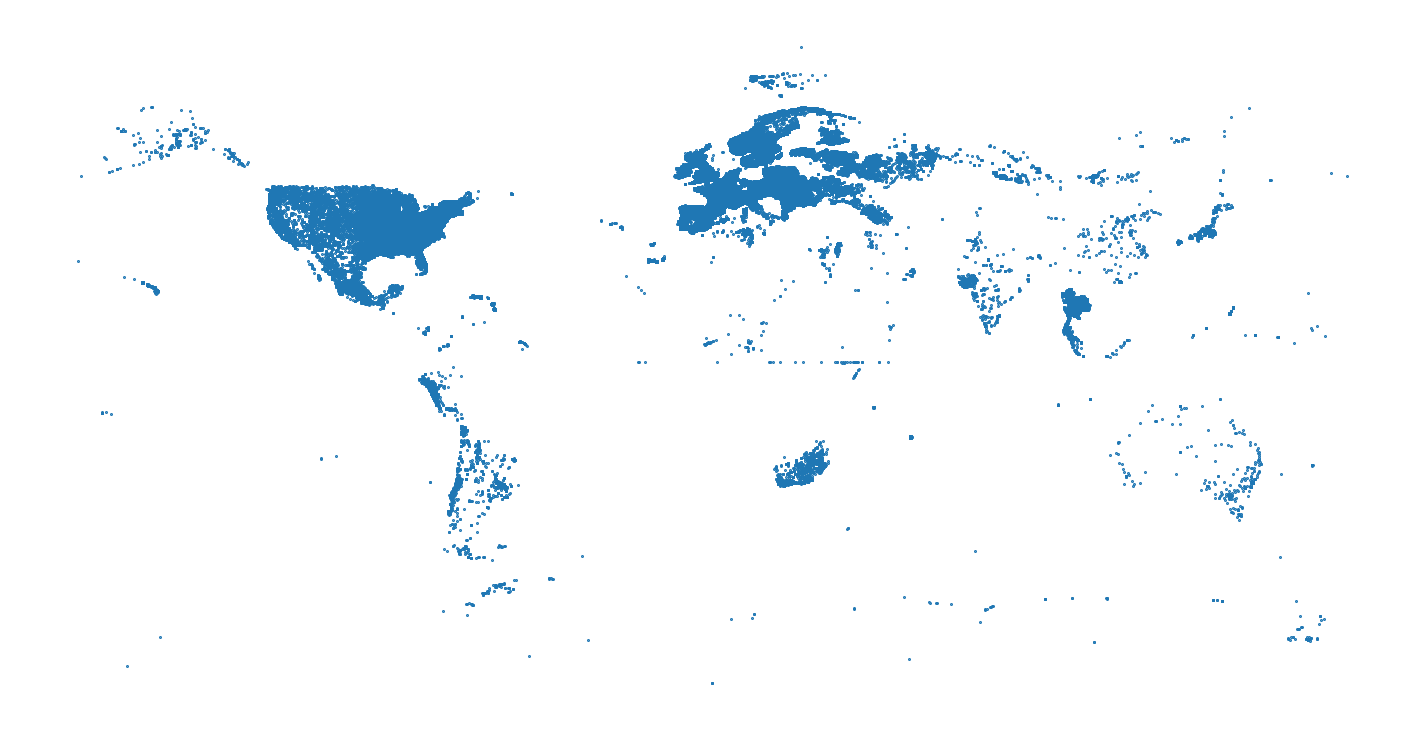

In [11]:
plot_wlm_spatial_distribution(geolocated_monuments)

**Count monuments per country**

In [12]:
geolocated_monuments.groupby(by='country').id.count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False) 

country   count
67  se-fornmin  135381
10      be-vlg  130609
20       de-by  107650
73          us   90472
54          nl   62461
..         ...     ...
75          uy       6
77          xk       4
69          sv       3
9       be-bru       3
76          ve       3

[79 rows x 2 columns]

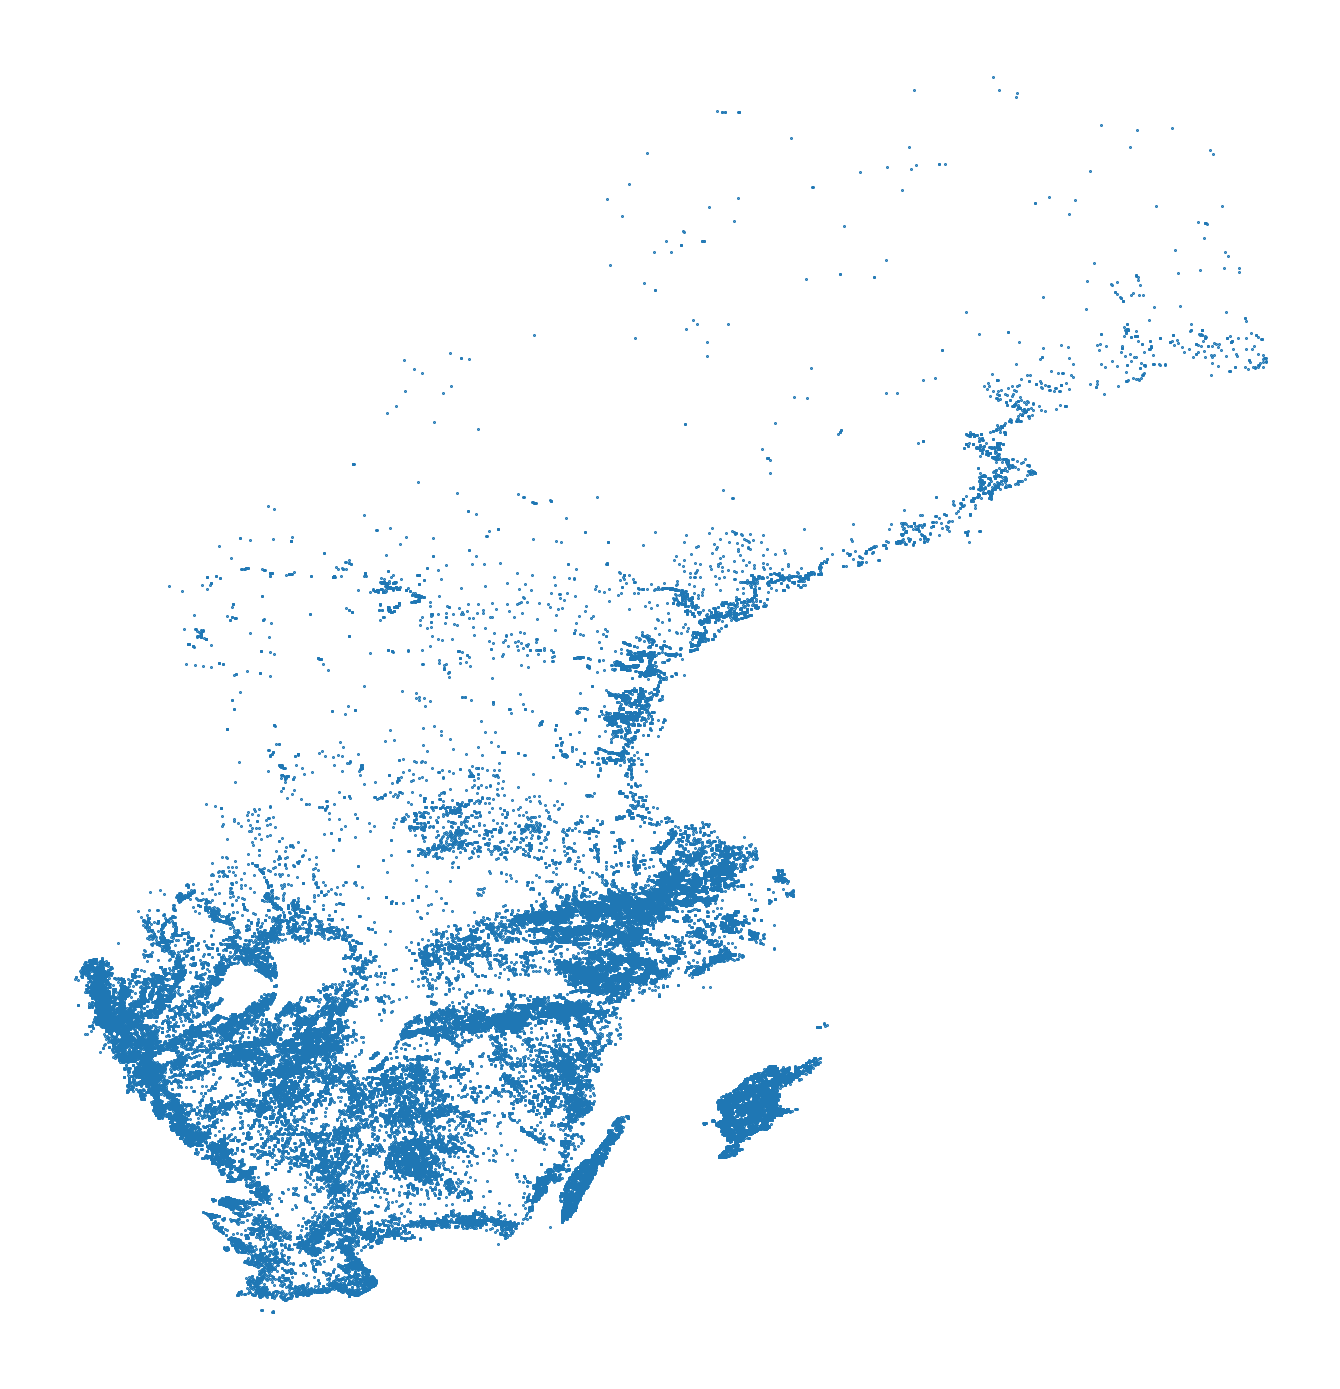

In [13]:
def filter_by_attr(df, attr, v):
    return df[df[attr]==v]
def filter_by_country(df, country):
    return filter_by_attr(df, 'country', country)
    
plot_wlm_spatial_distribution(filter_by_country(geolocated_monuments, 'se-fornmin'))

**Count monuments with a valid Wikidata entry**

In [14]:
geolocated_monuments[geolocated_monuments.wd_item.notnull()].groupby(by="country").id.count().reset_index(name='count') \
            .sort_values(['count'], ascending=False) 

country  count
9       nl  62209
3       cz  40535
5       es  34737
4    de-he  10349
11      pt   6931
6       fr   4478
12      ru   3312
1       at   1117
2       au    516
7   gb-eng    174
0       ad    120
8       ng      6
10  nl-gem      2

**Add here additional analyses with comments and references when available**

In [15]:
#TODO

**Characterize Wiki Loves Monuments snapshots**

In [16]:
import datetime

def convert_image_timestamp(x):
    try:
        return datetime.datetime.strptime(str(x), '%Y%m%d%H%M%S')
    except Exception as ex:
        return None

def load_wlm_snapshot(year):
    
    attrs = ['timestamp', 'pid', 'page_title', 'img_metadata',
       'img_description_id', 'img_actor', 'gt_lon', 'gt_lat','geometry', 'img_timestamp']
    
    
    wlm = pd.read_csv(PROJECT_BASE_DIR+"wlm_data_%d.tsv.bz2" %year, sep="\t", 
                      error_bad_lines=False, 
                      warn_bad_lines=False)
    print('Attributes: ', wlm.columns.values)
    wlm = wlm[wlm.gt_lon.apply(is_valid_lon)]
    wlm = wlm[wlm.gt_lat.apply(is_valid_lat)]
    # Check the timestamp format. img_timestamp has many issues (negative values or UNIX timestamp referring to date in the 80s)     
    wlm['img_timestamp'] = wlm['img_timestamp'].astype('int32')
    wlm['timestamp'] = wlm.img_timestamp.apply(lambda x: convert_image_timestamp(x))
    
    wlm['pid'] = wlm.gt_page_id.astype(int)
    wlm['img_actor'] = wlm['img_actor'].astype('int16')
    wlm['img_description_id'] = wlm['img_description_id'].astype('int16')
    wlm = wlm.filter(attrs)
    wlm = wlm.rename(columns={
        'page_title':'title', 
        'img_metadata': 'metadata' ,
        'img_description_id':'img_description_id', 
        'img_actor':'img_actor', 
        'gt_lon':'lon', 
        'gt_lat':'lat' 
    })
    wlm = wlm.drop_duplicates(subset=['pid'])
    
    return gpd.GeoDataFrame(wlm, geometry=gpd.points_from_xy(wlm.lon, wlm.lat))

In [17]:
wlm = load_wlm_snapshot(2013)

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (17,21,22,23,25,31,33,37,42,44,46) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Attributes:  ['cl_from' 'cl_to' 'cl_sortkey' 'cl_timestamp' 'cl_sortkey_prefix'
 'cl_collation' 'cl_type' 'page_id' 'page_namespace' 'page_title'
 'page_restrictions' 'page_is_redirect' 'page_is_new' 'page_random'
 'page_touched' 'page_links_updated' 'page_latest' 'page_len'
 'page_content_model' 'page_lang' 'img_name' 'img_size' 'img_width'
 'img_height' 'img_metadata' 'img_bits' 'img_media_type' 'img_major_mime'
 'img_minor_mime' 'img_description_id' 'img_actor' 'img_timestamp'
 'img_sha1' 'il_from' 'il_to' 'il_from_namespace' 'gt_id' 'gt_page_id'
 'gt_globe' 'gt_primary' 'gt_lat' 'gt_lon' 'gt_dim' 'gt_type' 'gt_name'
 'gt_country' 'gt_region']


In [18]:
wlm

timestamp       pid  \
0       4054-08-03 08:08:08  28360689   
5       4054-08-03 08:08:09  28360688   
9       4014-09-09 00:05:07  28268482   
14                     None  28791630   
17      4104-03-04 04:08:01  28468910   
...                     ...       ...   
198476  4104-04-05 04:08:07  28471510   
198477  4104-04-05 04:08:08  28471511   
198478  4104-04-05 04:09:05  28471513   
198479  4174-08-05 02:06:05  28718206   
198480  4174-08-05 02:06:05  28718205   

                                                    title  \
0       Castello_visto_da_monumento_"Porta_della_luce"...   
5       Castello_visto_da_monumento_"Porta_della_luce"...   
9       Chemische_in_Uetikon_am_See,_Ansicht_vom_Dampf...   
14           Estrellas_de_oro_en_Iglesia_de_la_Tirana.jpg   
17      Fontanellen_Ephemeral_Art_Construction_in_fron...   
...                                                   ...   
198476                                           黃屋-2.JPG   
198477                                           黃屋-3.JPG   
198478                                           黃屋-4.JPG   
198479                         龍門裡正角日軍上陸紀念碑1_peiiunwu.jpg   
198480                         龍門裡正角日軍上陸紀念碑2_peiiunwu.jpg   

                                                 metadata  img_description_id  \
0       a:42:{s:16:"ImageDescription";a:2:{s:9:"x-defa...                  44   
5       a:42:{s:16:"ImageDescription";a:2:{s:9:"x-defa...                  44   
9       a:55:{s:4:"Make";s:17:"NIKON CORPORATION";s:5:...               16454   
14      a:45:{s:4:"Make";s:17:"NIKON CORPORATION";s:5:...                  44   
17      a:44:{s:4:"Make";s:17:"NIKON CORPORATION";s:5:...                  44   
...                                                   ...                 ...   
198476  a:37:{s:4:"Make";s:5:"Apple";s:5:"Model";s:8:"...                  44   
198477  a:37:{s:4:"Make";s:5:"Apple";s:5:"Model";s:8:"...                  44   
198478  a:37:{s:4:"Make";s:5:"Apple";s:5:"Model";s:8:"...                  44   
198479  a:9:{s:11:"XResolution";s:5:"300/1";s:11:"YRes...                  44   
198480  a:9:{s:11:"XResolution";s:5:"300/1";s:11:"YRes...                  44   

        img_actor         lon        lat  img_timestamp  \
0           18443   11.356860  45.715340      405483888   
5           18443   11.356860  45.715340      405483889   
9             717    8.675277  47.252958      401499057   
14         -13128  -69.655954 -20.335872      489306404   
17          25989   13.194722  55.705833      410434481   
...           ...         ...        ...            ...   
198476      27527  114.174333  22.274000      410445487   
198477      27527  114.174333  22.274000      410445488   
198478      27527  114.174167  22.274000      410445495   
198479      18661  119.681657  23.554422      417485265   
198480      18661  119.681657  23.554422      417485265   

                           geometry  
0         POINT (11.35686 45.71534)  
5         POINT (11.35686 45.71534)  
9          POINT (8.67528 47.25296)  
14      POINT (-69.65595 -20.33587)  
17        POINT (13.19472 55.70583)  
...                             ...  
198476   POINT (114.17433 22.27400)  
198477   POINT (114.17433 22.27400)  
198478   POINT (114.17417 22.27400)  
198479   POINT (119.68166 23.55442)  
198480   POINT (119.68166 23.55442)  

[153965 rows x 10 columns]

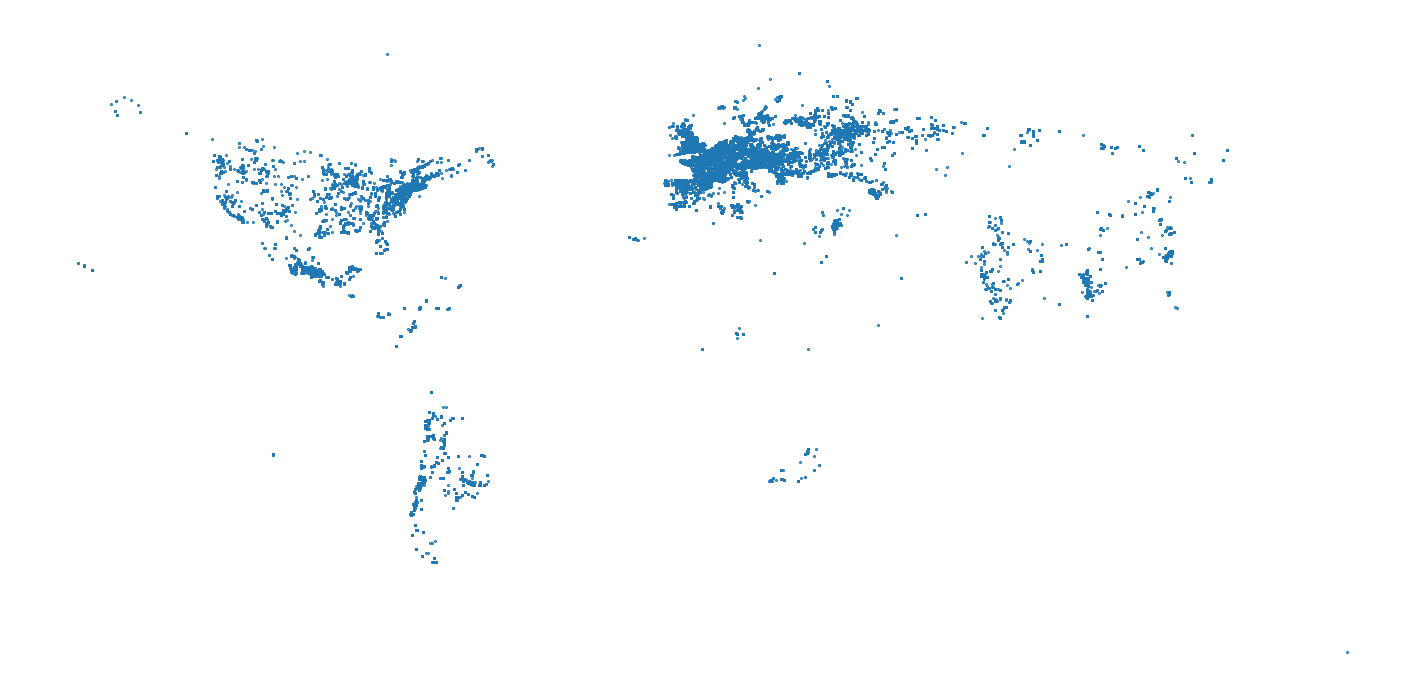

In [19]:
plot_wlm_spatial_distribution(wlm)

**Add here additional analyses with comments and references when available**

In [20]:
#TODO